#### Beta Distribution

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import beta
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, laplace, t

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact

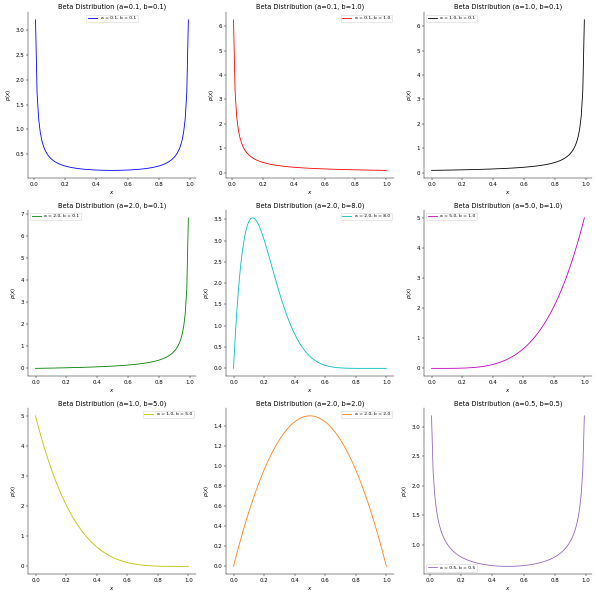

In [ ]:
import math
def graph(data):
    x = data['x']
    a_list = data['a_list']
    b_list = data['b_list']
    props = data['props']

    num_plots = len(a_list)
    ncols = 3
    nrows = math.ceil(num_plots / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows), dpi=40)

    # Handle cases where axs might be a single Axes object if nrows=ncols=1
    if num_plots == 1:
        axs = [axs]
    else:
        axs = axs.flatten() # Flatten the 2D array of axes for easy indexing

    for i, (a, b, prop) in enumerate(zip(a_list, b_list, props)):
        ax = axs[i] # Get the current subplot axis
        y = beta.pdf(x, a, b)
        ax.plot(x, y, prop, label='a = {}, b = {}'.format(a, b))

        ax.set_xlabel('$x$')
        ax.set_ylabel('$p(x)$')
        ax.legend(loc='best', prop={'size': 8})
        ax.set_title('Beta Distribution (a={}, b={})'.format(a, b))
        sns.despine(ax=ax) # Despine for the current subplot

    # Turn off any unused subplots
    for j in range(num_plots, nrows * ncols):
        if j < len(axs):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

x = jnp.linspace(0, 1, 100)
a_list = [0.1, 0.1, 1.0, 2.0, 2.0, 5.0, 1.0, 2.0, 0.5]
b_list = [0.1, 1.0, 0.1, 0.1, 8.0, 1.0, 5.0, 2.0, 0.5]
props = ['b', 'r', 'k', 'g', 'c', 'm', 'y', 'tab:orange', 'tab:purple']
data = {'x': x, 'a_list': a_list, 'b_list': b_list, 'props':props}
graph(data)

#### Bimodal Distribution - mixture 2-1D Gaussian

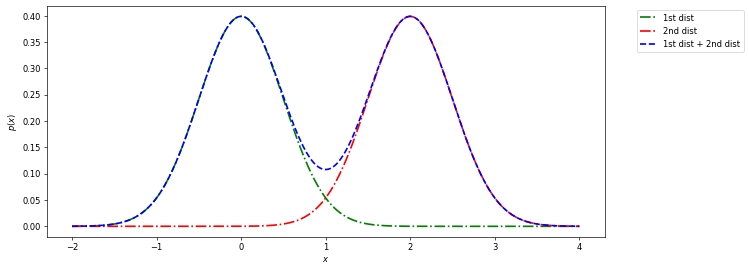

In [ ]:
def graph(ax, data, color=None, linestyle=None, label=None, xlabel=None, ylabel=None):
    line_width = 2
    x = data['x']
    weights = data['weights']
    distributions = data['distributions']
    p = sum(weights[i] * distributions[i].pdf(x) for i in range(len(distributions)) )

    ax.plot(x, p, color=color, linestyle=linestyle, linewidth=line_width, label=label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if xlabel: plt.xlabel('$x$')
    if ylabel: plt.ylabel('$p(x)$')

''' define distributions '''
data = dict()
mu = [0, 2]
sigma = [0.5, 0.5]
distributions = [norm(loc=mu[i], scale=sigma[i]) for i in range(2)]
x = jnp.linspace(-2, 2*mu[1], 600)
#p = sum(weights[i] * distributions[i].pdf(x) for i in range(2) )
weights = [0.5, 0.5]
data = {'distributions': distributions, 'weights': weights, 'x': x}

plt.figure(figsize=(12, 5), dpi=60)
ax = plt.gca()

mu = [0]
sigma = [0.5]
distributions = [norm(loc=mu[i], scale=sigma[i]) for i in range(1)]
data1 = {'distributions': distributions, 'weights': weights, 'x': x}
graph(ax, data1, color='g', linestyle='dashdot', label='1st dist')

mu = [2]
sigma = [0.5]
distributions = [norm(loc=mu[i], scale=sigma[i]) for i in range(1)]
data2 = {'distributions': distributions, 'weights': weights, 'x': x}
graph(ax, data2, color='r', linestyle='dashdot', label='2nd dist')

graph(ax, data, color='b', linestyle='dashed', label='1st dist + 2nd dist', xlabel='$x$', ylabel='$p(x)$')

#### Central Limit Theorem

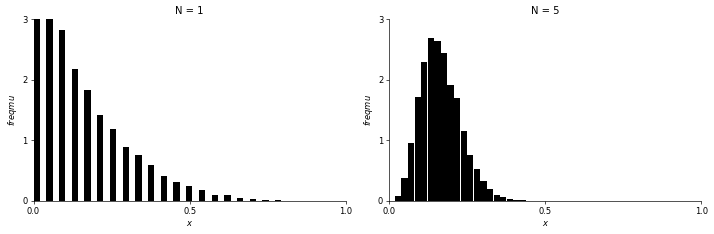

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp

# Modified plot_convolutionHist to accept an axes object
def plot_convolutionHist(ax, out, N, sample_size, bins):
    counts, nbins_loc = jnp.histogram(out, bins=bins)
    counts = counts / (sample_size / bins)

    # Plot directly on the provided axes
    ax.bar(nbins_loc[:-1], counts, width=0.02, align='edge', color='black')
    ax.set_xticks(jnp.linspace(0, 1, 3))
    ax.set_yticks(jnp.linspace(0, 3, 4))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)
    ax.set_title(f'N = {N}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$freq mu$')
    sns.despine(ax=ax) # Despine for the current subplot

key = jax.random.PRNGKey(1)
keys = jax.random.split(key, num=10000)
sample_size = 10000
bins = 20
N_array = [1, 5]

def mean_(keys, N):
    x = jnp.mean(jax.random.beta(keys, 1, 5, [1, N]))
    return x

# Create a single figure with subplots
fig, axs = plt.subplots(1, len(N_array), figsize=(12, 4), dpi=60) # 1 row, len(N_array) columns

for i, N in enumerate(N_array):
    means = jax.vmap(mean_, in_axes=(0, None), out_axes=0)
    out = means(keys, N)
    # Pass the specific subplot axis to the function
    plot_convolutionHist(axs[i], out, N, sample_size, bins)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

#### Monte Carlo approximation on Uniform distribution

mean: 0.3332834243774414, std: 0.2926672101020813


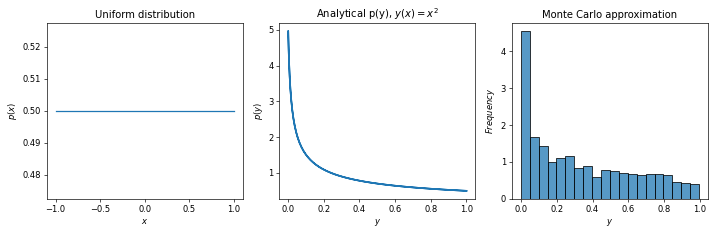

In [ ]:
x_samples = jnp.linspace(-1, 1, 100)
lower, upper = -1, 1
px_uniform = 1/(upper - lower)* jnp.ones(len(x_samples))
square_fn = lambda x: x**2
y = square_fn(x_samples)
y_pdf = 1/(2* jnp.sqrt(y + 1e-2))
n = 1000
key = random.PRNGKey(42)
uniform_samples = random.uniform(key, shape=(n, 1), minval=lower, maxval=upper)
fn_samples = square_fn(uniform_samples)

mean_sample = jnp.mean(fn_samples)
std_sample = jnp.std(fn_samples)
print(f'mean: {mean_sample}, std: {std_sample}')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=60)
ax[0].set_title('Uniform distribution')
ax[0].plot(x_samples, px_uniform, label='px_uniform')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$p(x)$')

ax[1].set_title('Analytical p(y), $y(x)=x^2$')
ax[1].plot(y, y_pdf, '-', linewidth=2)
ax[1].set_xlabel('$y$')
ax[1].set_ylabel('$p(y)$')

ax[2].set_title('Monte Carlo approximation')
# Use sns.histplot for the histogram; stat='density' replaces norm_hist=True
sns.histplot(fn_samples.flatten(), kde=False, ax=ax[2], bins=20, stat="density")
ax[2].set_xlabel('$y$')
ax[2].set_ylabel('$Frequency$')
plt.tight_layout()
plt.show()

#### Binomial Distribution - pmf of Binomial with varying probability of success

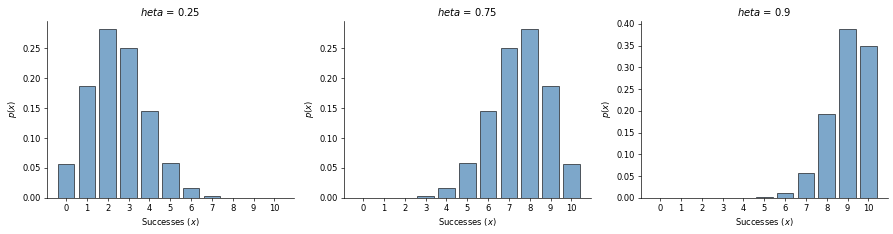

In [ ]:
import scipy.stats as stats
import numpy as np

N = 10
thetas = [0.25, 0.75, 0.9]
x = np.arange(0, N + 1)

fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=60)
axs = axs.flatten()

for i, theta in enumerate(thetas):
    ax = axs[i]
    pmf = stats.binom.pmf(x, N, theta)
    ax.bar(x, pmf, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(f'$\theta$ = {theta}')
    ax.set_xlabel('Successes ($x$)')
    ax.set_ylabel('$p(x)$')
    ax.set_xticks(x)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()